<span style="float: left;padding: 1.3em">![logo](https://drive.google.com/uc?id=1zbQJxqu8KdXdC0IgCtiHqUtAYiziQxfw)</span>

# XV Taller de la División de Gravitación y Física Matemática

## Búsqueda y detección de Ondas gravitacionales con datos abiertos.

#### Tutorial 1: Obtención y visualización de señales.

Este tutorial está dividido en dos partes. En la primera aprendemos a realizar búsquedas de señales gravitacionales en el catálogo de datos abiertos obtenidos en las corridas en cada observatorio de la colaboración LVK, a través del GWOSC (Gravitational Wave Open Science Center), que dispone de un amplio catálogo de señales de Compact Binary Coalescences (CBCs), y podemos acceder a cada una usando la librería de python [gwosc](https://gwosc.readthedocs.io/en/stable/).

Por otro lado, en la segunda parte veremos qué datos se tienen sobre las señales de Core-Collapse Supernova. Los cuáles provienen principalmente de simulaciones numéricas en 2D y 3D.

## 1. Colisiones de Agujeros Negros Binarios

### Configuración previa

Esta librería puede instalarse en un ambiente virtual a través del comando pip, seguimos las mismas líneas de código para un notebook si es que no está previamente instalada.

In [19]:
!pip install gwosc

In [21]:
import gwosc

In [4]:
import lal as _lal # Línea de código para importar características de la librería en C lalsuite

###1.1 Catálogo de Colisiones de Objectos Compactos
Podemos utilizar la API que provee GWOSC para recuperar datos sobre los eventos registrados de la colisión de agujeros negros.

Para realizar un búsqueda en el catálogo, se usa la función `find_datasets()` que recibe como parámetros `type` que nos permite buscar por catálogo, corrida de observación o evento. También `match` para buscar datasets que contengan una palabra (evento o nombre de un catálogo), `detector` y `segment` que es el tiempo GPS en el que se realiza la búsqueda.


In [24]:
from gwosc.datasets import find_datasets
from gwosc import datasets

print("Los catálogos disponibles son: ")
print(find_datasets(type="catalog"))

Los catálogos disponibles son: 
['GWTC', 'GWTC-1-confident', 'GWTC-1-marginal', 'GWTC-2', 'GWTC-2.1-auxiliary', 'GWTC-2.1-confident', 'GWTC-2.1-marginal', 'GWTC-3-confident', 'GWTC-3-marginal', 'Initial_LIGO_Virgo', 'O1_O2-Preliminary', 'O3_Discovery_Papers', 'O3_IMBH_marginal', 'O4_Discovery_Papers']


In [26]:
# Buscar eventos en un catálogo específico
gwtc1 = datasets.find_datasets(type='events', catalog='GWTC-1-confident')
print('Eventos del GWTC-1:', gwtc1)

Eventos del GWTC-1: ['GW150914-v3', 'GW151012-v3', 'GW151226-v2', 'GW170104-v2', 'GW170608-v3', 'GW170729-v1', 'GW170809-v1', 'GW170814-v3', 'GW170817-v3', 'GW170818-v1', 'GW170823-v1']


In [27]:
# Datos de las corridas completas
runs = find_datasets(type='run')
print('Large data sets:', runs)

Large data sets: ['BKGW170608_16KHZ_R1', 'O1', 'O1_16KHZ', 'O2_16KHZ_R1', 'O2_4KHZ_R1', 'O3GK_16KHZ_R1', 'O3GK_4KHZ_R1', 'O3a_16KHZ_R1', 'O3a_4KHZ_R1', 'O3b_16KHZ_R1', 'O3b_4KHZ_R1', 'S5', 'S6']


In [29]:
print(datasets.find_datasets(type='events', catalog='GWTC-1-confident', detector="H1", segment=(1164556817, 1187733618)))

['GW170104-v2', 'GW170608-v3', 'GW170729-v1', 'GW170809-v1', 'GW170814-v3', 'GW170817-v3', 'GW170818-v1', 'GW170823-v1']


Podemos usar también la función `event_gps` para obtener el tiempo GPS de un evento y la función `event_at_gps` para hacer lo opuesto.

In [30]:
from gwosc.datasets import event_gps
from gwosc.datasets import event_at_gps

gps = event_gps('GW190425')
print(gps)

print(event_at_gps(gps))

1240215503.0
GW190425


Además, podemos hallar los tiempos GPS en que inició y finalizó una corrida, utilizando `run_segment()`

In [55]:
from gwosc.datasets import run_segment
S5 = run_segment('S5')
print('Tiempo inicial y final de la corrida S5: ', S5)

Tiempo inicial y final de la corrida S5:  (815155213, 875232014)


### 1.2 Accesando a los datos de LIGO-VIRGO-KAGRA

Es posible recuperar los datos para el evento en específico o para toda la corrida de observación y almacenarlos como una serie de tiempo. Para ello, podemos usar la paquetería GWOSC en conjunto con GWpy para nuestras búsquedas y recuperar los datos deseados.

Tomemos como ejemplo el evento de la primera detección de una OG, GW150914. Para poder descargar los datos directamente de GWOSC, necesitamos conocer su tiempo GPS:

In [33]:
! pip install gwpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 15.4 MB/s eta 0:00:00


In [35]:
import gwpy

In [31]:
gps = event_gps('GW150914')
print(gps)

1126259462.4


Dado que la función que nos permite recuperar un evento por su tiempo GPS, solamente considera una ventana de 1 segundo alrededor del tiempo dado, hay que ampliar la búsqueda a un segmento, por ejemplo de 10 segundos.

In [32]:
segmento = (int(gps)-5, int(gps)+5) #Se convierte a enteros para evitar intervalos estrictos y no recuperar datos si estos se hallan en los extremos
print(segmento)

(1126259457, 1126259467)


In [36]:
# Recuperar datos de Hanford
from gwpy.timeseries import TimeSeries
han_data = TimeSeries.fetch_open_data('H1', *segmento, verbose=True)
print(han_data)

Fetched 1 URLs from gwosc.org for [1126259457 .. 1126259467))
Reading data... [Done]
TimeSeries([-3.37408113e-19, -3.60538427e-19, -3.22327735e-19,
            ...,  1.52206625e-19,  1.58897479e-19,
             1.71197631e-19]
           unit: dimensionless,
           t0: 1126259457.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


Para saber exactamente de qué catálogo se recuperan los datos, se puede especificar `type` y `dataset`. Esto es útil ya que se actualizan los catálogos de acuerdo con los datos de calibración de los detectores. Una vez recuperada la serie de tiempo, podemos graficarla usando matplotlib.

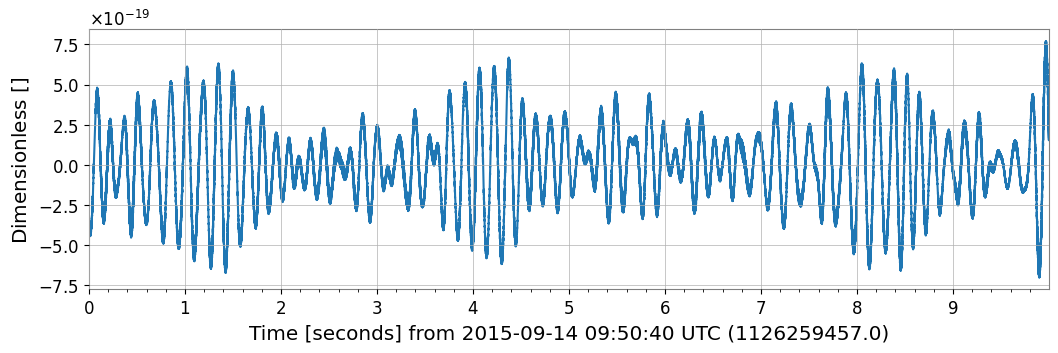

In [37]:
import matplotlib.pyplot as plt
han_data.plot()

## 1.3 Formas de onda para BBH
Para poder encontrar formas de onda, embebidas en ruido, muchas técnicas hacen uso de aquellas plantillas encontradas mediante la fórmula cuadrupolar obtenida al resolver la ecuación de onda de la gravedad linealizada, o por simulación numérica u otras técnicas que permiten hallar una forma de onda aproximada para Agujeros negros binarios. Este tipo de formas de onda, también llamadas *aproximantes* pueden graficarse usando la pipeline de PyCBC que nos permite generar formas de onda variando los parámetros del sistema progenitor.

In [117]:
!pip install pycbc

In [118]:
from pycbc.waveform import get_td_waveform, fd_approximants #En el dominio del tiempo o frecuencia
import pylab

Para generar una forma de onda necesitamos las masas de los agujeros negros (en masas solares), la frecuencia de muestreo y la frecuencia inicial de la onda gravitacional.

In [119]:
from pycbc.waveform import td_approximants, fd_approximants

print('Dominio del tiempo: ', td_approximants())
print('Dominio de la frecuencia: ', fd_approximants())

Dominio del tiempo:  ['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'IMRPhenomT', 'IMRPhenomTHM', 'IMRPhenomTP', 'IMRPhenomTPHM', 'SEOBNRv4HM_PA', 'pSEOBNRv4HM_PA', 'IMRPhenomXAS_NRTidalv2', 'IMRPhenomXP_NRTidalv2'

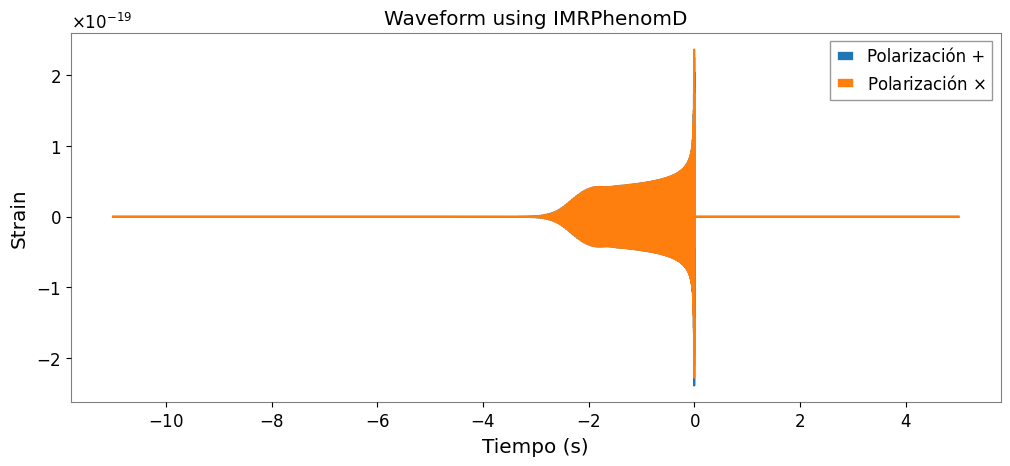

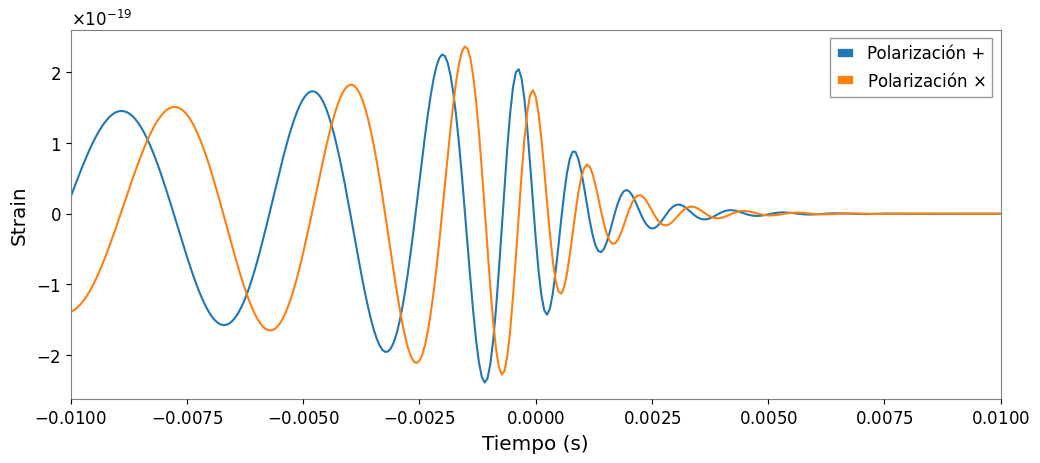

In [132]:
#Calcular ambas polarizaciones para la forma de onda
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/16384,
                         f_lower=30)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Polarización +')
pylab.plot(hp.sample_times, hc, label=r'Polarización $\times$')
pylab.xlabel('Tiempo (s)')
pylab.title('Waveform using IMRPhenomD')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Polarización +')
pylab.plot(hp.sample_times, hc, label=r'Polarización $\times$')
pylab.xlabel('Tiempo (s)')
pylab.ylabel('Strain')
pylab.xlim(-.01, .01) #zoom cerca de la fusión
pylab.legend()
pylab.grid()
pylab.show()

## Ondas gravitacionales de Supernovas por colapso de núcleo.

Como ya se mencionó anteriormente, este tipo de ondas no se han detectado aún en los observatorios de la red LVK, sin embargo se han realizado simulaciones en 2D y 3D para poder entender cómo ser vería la forma de onda variando ciertos parámetros físicos de la estrella progenitora.

Por ejemplo, Harald Dimmelmeier, realizó simulaciones en dos dimensiones (para este caso debido a la simetría axial $h_{\times} = 0$) y solamente tenemos la polarización $h_{+}$. El [catálogo](https://www.mpa-garching.mpg.de/177514/Gravitational-Waveform-Catalog) está compuesto por 54 formas de onda para 3 grados de rotación diferencial diferentes y 18 porcentajes de rotación, desde el 0.05% hasta 4%.

El catálogo de Dimmelmeier se encuentra disponible para consultar. Consiste de una carpeta con 54 archivos .dat, para abrirlos cargamos a nuestro directorio la carpeta.

In [124]:
import pandas as pd

In [125]:
# Posibles valores para los nombres de los archivos
a = ['a1','a2','a3']
b = ['b0.05','b0.07','b0.10','b0.15','b0.25','b0.35','b0.50','b0.70','b0.90','b1.10','b1.30','b1.60','b1.80','b2.00','b2.50','b3.00','b3.50','b4.00']

In [127]:
signals = {}
for A in a:
  for B in b:
    signals['signal_'+str(A)+str(B)] = pd.read_csv('/content/signal_data/signal_'+str(A)+str(B)+'.dat', delimiter='\t',names=['values'])

In [128]:
# Función para procesar datos, quitar espacios innecesarios, convertir tipo de datos etc.
def pre_process(data):
    series = data.str.strip()
    series_split = series.str.split(n=1, expand=True)
    series_split = series_split.astype(float)

    gw_data = pd.DataFrame({'time':series_split[0], 'strain':series_split[1]})
    return gw_data

In [129]:
new_signals = {}
for i in signals:
  new_signals[i] = pre_process(signals[i]['values'])

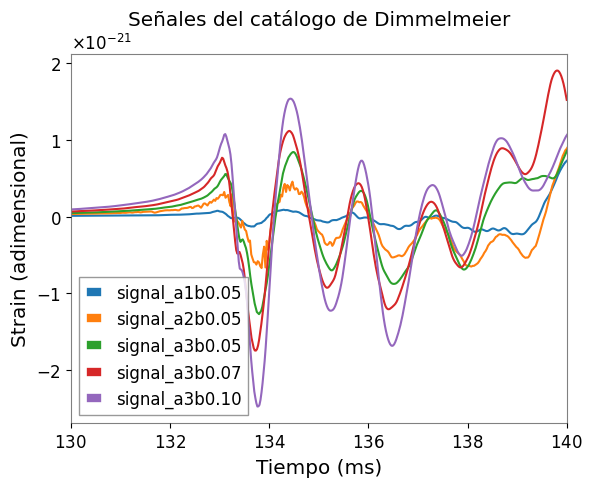

In [133]:
plt.plot(new_signals['signal_a1b0.05']['time']+1.2,new_signals['signal_a1b0.05']['strain'],label='signal_a1b0.05')
plt.plot(new_signals['signal_a2b0.05']['time']+0.8,new_signals['signal_a2b0.05']['strain'],label='signal_a2b0.05')
plt.plot(new_signals['signal_a3b0.05']['time']+0.5,new_signals['signal_a3b0.05']['strain'],label='signal_a3b0.05')
plt.plot(new_signals['signal_a3b0.07']['time'],new_signals['signal_a3b0.07']['strain'],label='signal_a3b0.07')
plt.plot(new_signals['signal_a3b0.10']['time']-0.6,new_signals['signal_a3b0.10']['strain'],label='signal_a3b0.10')

plt.legend()
plt.xlim(130,140)
plt.title("Señales del catálogo de Dimmelmeier")
plt.xlabel('Tiempo (ms)')
plt.ylabel('Strain (adimensional)')
plt.grid()


### Pregunta 1
¿Cuántos meses duró la corrida O1? Considera que el mes tiene 30 días.

### Pregunta 2
Añade ruido gaussiano blanco a cualquiera de las dos señales, con $\mu =0$ y $\sigma = 1\times10^{-18}$. Considera que para una serie de tiempo con ruido $s(t) = h(t) + n(t)$. Donde $s$ es la observación $h$ la señal gravitacional y $n$ el ruido. Grafica los resultados.